In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In this project, for the TensorFlow layers, model has used LeakyReLU and BatchNormalization, which are both commonly used in GAN's.

In [2]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
# Load in the data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale the data to be between (-1, 1), so that image pixels are centered around zero, that can be achived by - dividing by 255, which puts the data between 0 & 1 and then (*2 - 1). 
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)


In [4]:
# We get shape of data - N * H * W 
# And Flatten the data to be tabulated
# Other options would be to use images directly using convolutional GAN

N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D) # So now it's N * D
x_test = x_test.reshape(-1, D)

In [6]:
# Set the dimensionality of the latent space
latent_dim = 100

In [7]:
# Build generator model, as input it takes in a vector from the latent space & after that it has pretty standard set of layers.
# Final activation funtion ='tanh': because our image pixels are centered to be between (-1, 1), we want to end this with a Tanh

def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [8]:
# Building discriminator model, it's a 3-Dense layer neural network with one output and Sigmoid activation, since this is binary classification.

def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [9]:
# Compile both models (generator & discriminator) in preparation for training


# 1st - Build and compile the discriminator, without input dimensionality= D
# Model compile the discriminator with binary_crossentropy loss & Adam optimizer
# And get the accuracy metric during training.
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])


# Next, Build a generator with input dimensionality = latent_dim
# This generator model isn't going to be used directly during training.
# We need to create a combined model, when an input goes through both generator & discriminator.

# So, we Build and compile the combined model
generator = build_generator(latent_dim)

# Next, Create a new input - Z to represent noise sample, it has dimensionality- latent space
z = Input(shape=(latent_dim,))

# Pass noise (z) through generator (a combined model) using functional API to get an image.
img = generator(z)

# For the combined model, we want to freeze the weights of the discriminator, so that only the generator is trained
# SO we set trainable = False for the discriminator model.
discriminator.trainable = False

# Next, pass in our image variable, which was the output of the generator through the discriminator model.
# We call it, fake_pred, meaning that it's an output prediction from our discriminator for our fake images.
fake_pred = discriminator(img)

# Fianlly, we Create a new model object- combined model, which takes as input - noise samples (Z) and produces the output fake_pred.
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [10]:
# Train the GAN

# Config set up before, we begin training 
batch_size = 32
epochs = 30000
sample_period = 200 # every `sample_period` steps generate and save some data

# labels - because we'll always have the same labels, it would be best to create them before, we strat traning and have to instantiate new objects later on inside a loop.
# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)      # set of ones of batch size
zeros = np.zeros(batch_size)    # set of zeros of batch size

# Two list to store the losses
d_losses = []
g_losses = []

# Create a folder to store the images we're going to generate durning training.
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [11]:
# sample_images() - which is a function to generate a grid of random samples from the generato & save those images to an image file.

# The idea is, we are going to have a grid of generatored images of size 5*5 , so in total, 25 images.
# 1st- we initialize rows & cells to five
# Next, we generate random noise vectors from the latent space, which we can have by calling Z.
# 

def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim) # this will be size 25 * 100 (number of sample by number of dimensions)
  imgs = generator.predict(noise) # passing in the noise to get our 25 generated samples.

  # Next, we Rescale images between 0 & 1, as the generator will generate images to be between (-1 & 1)
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)       # to get, a figure object & axis object, where we are going to store our plots.
  idx = 0                                   # which is going to count up to 25 to index the images we just generated.
  for i in range(rows):                     # Loop through each i entry, in the axs object.
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray') # reshape the image by height * width & in grayscale.
      axs[i,j].axis('off')                  #axis = off,so we don't see lines in our plots.
      idx += 1                              # increment count for the next iteration in the loop
  fig.savefig("gan_images/%d.png" % epoch)  # save figure to the png file.
  plt.close()                               # clean up any resources.

In [12]:
# Main training loop
# There are 2 major steps in this loop.
# 1st - train the discriminator model & 2nd - train the generator model

# To train discriminator -
# we need both real & fake images. We can get real images, by sampling from random indices from zero up to number of samples in X_train.
# Then we can get actual images, by indexing next train at those indices [idx].

# To train the generator - 
# we want to generate fake images using the generator, so first we create some random noise sampled from the standard normal in our latent space.
# Then we call generated predict with this noise as input, this gives us our fake images.
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator on batch
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)   # here,we pass in the real images & ones vector to denote - these belong to positive class.
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)  # (fake_imgs, zeros)to denote, these blongs to negative class

  # In order to calculate the overall loss & accuracy, the model is going to take mean of these losses & accuracy's.
  d_loss = 0.5 * (d_loss_real + d_loss_fake)                                # compute lass
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)                                  # compute accuracy
  
  
  #######################
  ### Train generator ###
  #######################
  # for training generator, we need fake images only. SO generate noise using the same method as before.
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones) # input= noise & target=ones vector. 
  # Here, we are trying to trick the discriminator into thinking that the images from the generator are real.
  
  # do it again!
  # noise = np.random.randn(batch_size, latent_dim)
  # g_loss = combined_model.train_on_batch(noise, ones)
  
  # Save the both losses
  d_losses.append(d_loss) # discriminator loss
  g_losses.append(g_loss) # generator loss
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch) # this will generate 25 images save them as png files.

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
epoch: 25101/30000, d_loss: 0.58,       d_acc: 0.69, g_loss: 1.03
1/1 [==============================] - 0s 37ms/step
epoch: 25201/30000, d_loss: 0.60,       d_acc: 0.69, g_loss: 1.08
1/1 [==============================] - 0s 30ms/step
epoch: 25301/30000, d_loss: 0.65,       d_acc: 0.61, g_loss: 1.11
1/1 [==============================] - 0s 50ms/step
epoch: 25401/30000, d_loss: 0.62,       d_acc: 0.62, g_loss: 0.84
1/1 [==============================] - 0s 25ms/step
epoch: 25501/30000, d_loss: 0.63,       d_acc: 0.66, g_loss: 1.12
1/1 [==============================] - 0s 39ms/step
epoch: 25601/30000, d_loss: 0.59,       d_acc: 0.67, g_loss: 0.95
1/1 [==============================] - 0s 24ms/step
epoch: 25701/30000, d_loss: 0.70,       d_acc: 0.56, g_loss: 1.07
1/1 [==============================] - 0s 39ms/step
epoch: 25801/30000, d_loss: 0.59,       d_acc: 0.67, g_loss: 0.92
1/1 [

So if we look at the accuracy values, we can see that despite the discriminator training, it never reaches high accuracy. This is because, while the discriminator is improving, so too the generator. 

And tha's exactly we want, because we want the generator to be able to create realistic images.

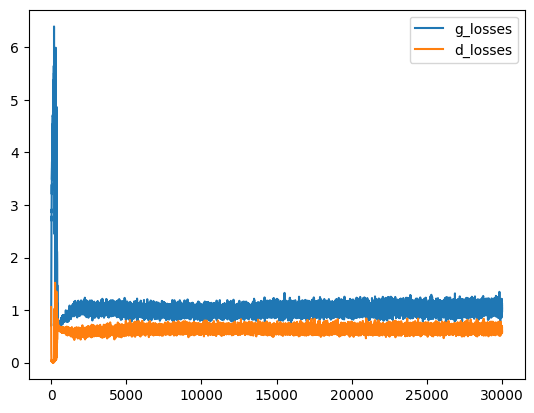

In [13]:
# plot the losses
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

Here, we can see that, after the first few iterations, both losses just hover around the same point. This is the case, even though both the generator and discriminator are improving during this time, their losses should reamain relatively the same throughout the training process because the generator and discriminator are fedding off of each other and improving in tandem.

In [14]:
# Check the images files, that we have created, as expected- we see multiple png files with epoch number as the file name.
!ls gan_images

0.png	   13800.png  17800.png  21600.png  25600.png  29600.png  6600.png
10000.png  14000.png  18000.png  21800.png  25800.png  29800.png  6800.png
1000.png   1400.png   1800.png	 22000.png  26000.png  3000.png   7000.png
10200.png  14200.png  18200.png  2200.png   2600.png   3200.png   7200.png
10400.png  14400.png  18400.png  22200.png  26200.png  3400.png   7400.png
10600.png  14600.png  18600.png  22400.png  26400.png  3600.png   7600.png
10800.png  14800.png  18800.png  22600.png  26600.png  3800.png   7800.png
11000.png  15000.png  19000.png  22800.png  26800.png  4000.png   8000.png
11200.png  15200.png  19200.png  23000.png  27000.png  400.png	  800.png
11400.png  15400.png  19400.png  23200.png  27200.png  4200.png   8200.png
11600.png  15600.png  19600.png  23400.png  27400.png  4400.png   8400.png
11800.png  15800.png  19800.png  23600.png  27600.png  4600.png   8600.png
12000.png  16000.png  20000.png  23800.png  27800.png  4800.png   8800.png
1200.png   1600.png   2000.png

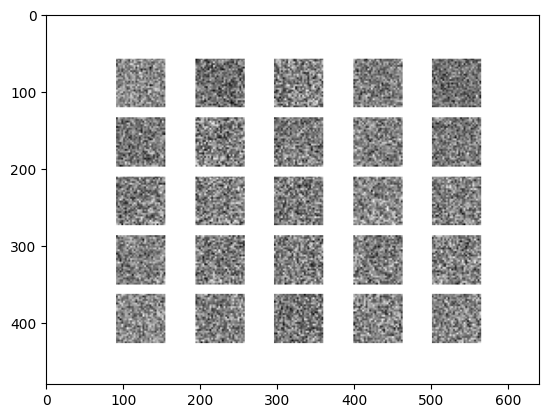

In [15]:
from skimage.io import imread
# Now, of course, we're going to have a look at some of these images.

# Here I decided to plot images from -
# epoch 0, which is right at the beginning of training.
# epoch 1000, which is still early on in the training process.
# epoch 5000, which is about 1/6th of the way through.
# epoch 10,000 which is 25% of the way through.
# and epoch 20,000, which is about 50% of the way through.
# and finally 29,800, which is the last epoch in which images were saved

a = imread('gan_images/0.png')
plt.imshow(a)

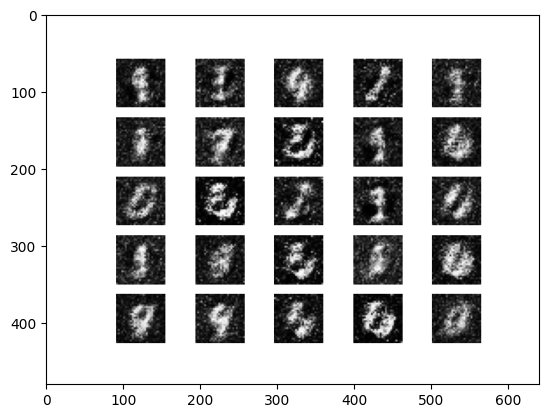

In [16]:
a = imread('gan_images/1000.png')
plt.imshow(a)

After the first 3rd of the way through, things already looks descent.

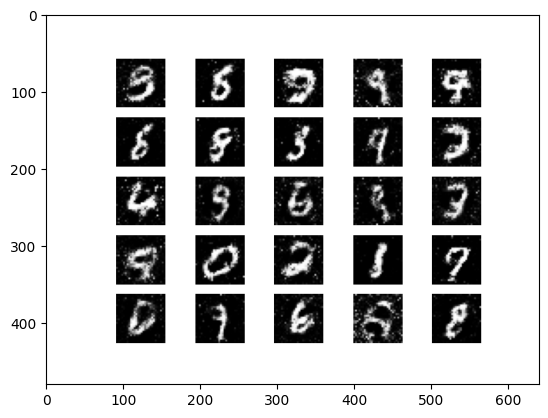

In [17]:
a = imread('gan_images/5000.png')
plt.imshow(a)

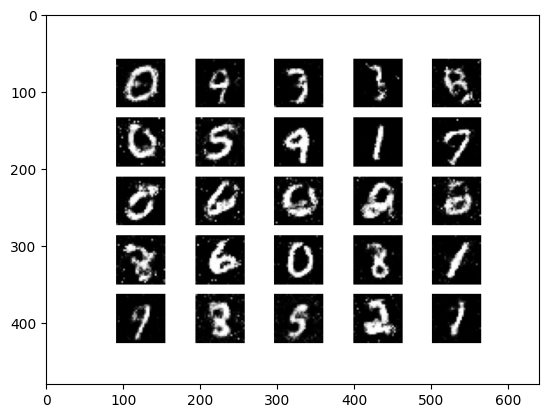

In [18]:
a = imread('gan_images/10000.png')
plt.imshow(a)

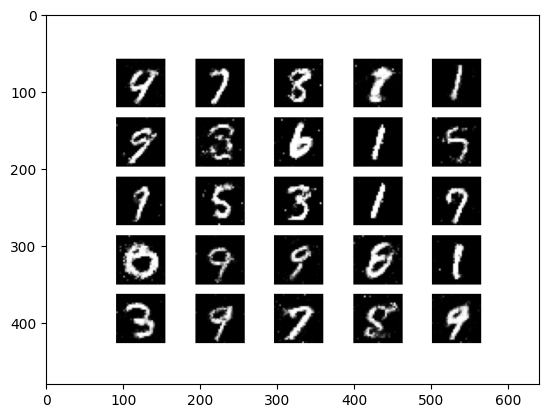

In [19]:
a = imread('gan_images/20000.png')
plt.imshow(a)

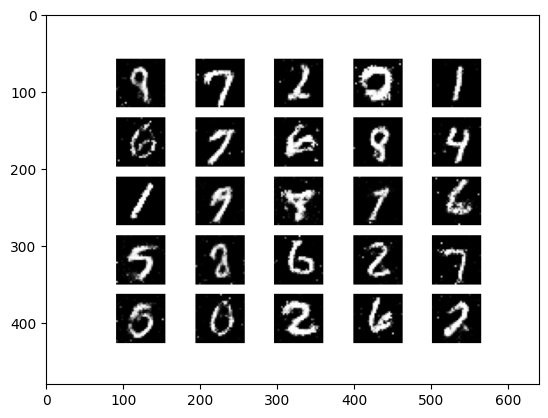

In [20]:
a = imread('gan_images/29800.png')
plt.imshow(a)

As we can see, the results are descent. We can clearly say model has performed as it gone through iteration rounds/epochs. 

At the beginning, we don't see anything at all and by the end it looks pretty much got better.

The generator learns to generate real looking digits quite quickly. So there's an aspect of diminishing returns here.